In [1]:
import os
import subprocess as sp
import nibabel as nib
import numpy as np
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

from config import root
import subprocess as sp
from nipype.interfaces import fsl, freesurfer

from tools.helpers import save_nii, mni2index, index2mni
import scipy
from scipy.special import gammaln
from scipy import ndimage
import scipy.ndimage.filters as filters
from scipy import signal as s
from scipy.ndimage import convolve
from tools.roi_selection import Cluster, Sphere
import matplotlib.gridspec as gridspec

In [2]:
dark = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#000000","#888888"])
darkgray = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#444444", "#444444"])
darkblue = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#8888ff", "#0000ff"])
darkred = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ff8888","#ff0000"])
white = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ffffff","#ffffff"])

In [3]:
def create_subplots(n, ncols=None, **kwargs):
    
    if ncols is None:
        ncols = round(n ** .5)
        
    nrows = int(np.ceil(n / ncols))
    rest = n % ncols
    col_width = (ncols - rest) % 2 + 1
    padding = int((ncols - rest) * col_width / 2)
    fig = plt.figure(**kwargs)
    gs = gridspec.GridSpec(nrows, col_width * ncols)

    axes = []
    
    for i in range(n - (n % ncols)):
        row = i // ncols
        col = i % ncols
        ax = fig.add_subplot(gs[row, col * col_width : (col+1) * col_width])
        axes.append(ax)
        
    for j in range(n % ncols):
        ax = fig.add_subplot(gs[nrows-1, (padding + col_width * j): (padding + col_width * (j+1))])
        axes.append(ax)
        
    return fig, axes

In [4]:
def fdr( zscores, q=.1, cV=1, invert_zscores=False, mask=None ):
    """
    Adapted from https://brainder.org/2011/09/05/fdr-corrected-fdr-adjusted-p-values/
    using a default value of cV
    """
    
    if mask is None:
        mask = np.ones(zscores.shape, dtype=bool)

    inv = -1 if invert_zscores else 1
    zscores = inv * zscores
    
    mask *= (zscores != 0)
    zscores = zscores[mask]
    pvals = norm.sf(zscores)
    
    oidx = np.argsort( pvals )
    pvals = pvals[oidx]
    
    V = pvals.size
    idx = np.arange(1, V+1)
    thrline = idx * q / ( V * cV )
    
    select = pvals <= thrline
    if len(pvals[select]):
        thr = np.max(pvals[select])
        zthr = zscores[oidx][select][-1] * inv
    else:
        thr = None
        zthr = None
        
    pcor = pvals * V * cV / idx
    oidx_r = np.argsort(oidx)
        
    padj = np.zeros(len(pvals))
    prev = 1
    
    for i in idx[::-1]:
        padj[i-1] = np.min( [prev, pvals[i-1] * V * cV / i] )
        prev = padj[i-1]
        
    return thr, zthr, pvals, thrline, pcor, padj

342 342 342


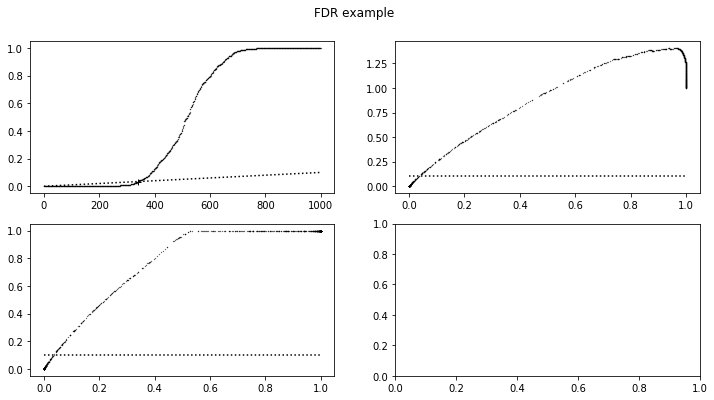

In [5]:
zscores = np.random.randn(10, 10, 10) * 4

qval = .1
thr, zthr, pvals, thrline, pcor, padj = fdr(zscores, q=qval)

fig, axes = create_subplots(4, figsize=(12, 6))
fig.suptitle("FDR example")
fig.subplots_adjust(top=.9)

axes[0].plot(pvals, "k.", markersize=.5)
axes[0].plot(np.arange(len(pvals))[pvals <= thr].max(), thr, "k+")
axes[0].plot(thrline, "k:")
axes[1].plot(pvals, pcor, "k.", markersize=.5)
axes[1].hlines(y=qval, xmin=0, xmax=1, linestyle=":")
axes[2].plot(pvals, padj, "k.", markersize=.5)
axes[2].hlines(y=qval, xmin=0, xmax=1, linestyle=":")

print(
    (pvals <= thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [6]:
def get_axes_peaks(img, thr, axis=0, plot=True, invert=-1):
    
    smooth = ndimage.gaussian_filter(img, sigma=(1,1,1), order=0)

    im = smooth.mean(axis=axis)
    dim = img.shape
    dim = np.delete(np.array(dim), axis)
    
    xs2 = np.arange(dim[0])
    ys2 = im.mean(axis=1)
    ypeaks2 = s.find_peaks_cwt(ys2*invert, np.arange(1, 7))
    ypeaks2 = ypeaks2[(ys2[ypeaks2] * invert)> np.abs(thr)]

    xs3 = np.arange(dim[1])
    ys3 = im.mean(axis=0)
    ypeaks3 = s.find_peaks_cwt(ys3*invert, np.arange(1, 7))
    ypeaks3 = ypeaks3[(ys3[ypeaks3] * invert)> np.abs(thr)]
    
    if plot:
    
        fig = plt.figure()
        ax1 = fig.add_subplot(2,2,1)
        ax1.imshow(im, aspect="auto", cmap="hot")

        ax2 = fig.add_subplot(2,2,2)    
        ax2.plot(ys2, xs2, color="black")    
        ax2.plot(ys2[ypeaks2], ypeaks2, marker="o", linestyle="none", color="black")   
        ax2.set_ylim(dim[0], 0)
        ax2.set_xlim(ys2.max(), ys2.min()-.05)

        ax3 = fig.add_subplot(2,2,3)
        ax3.plot(xs3, ys3, color="black")
        ax3.plot(ypeaks3, ys3[ypeaks3], marker="o", linestyle="none", color="black")
        ax3.set_xlim(0, dim[1])
        ax3.set_ylim(ys3.min(), ys3.max())
        
    return ypeaks2, ypeaks3


def plot_slices(img, thr, slices, axis, ncols=None, **kwargs):
    
    index = [slice(None)]*3
    
    if ncols is None:
        ncols = round(len(slices) ** .5)
        
    nrows = int(np.ceil(len(slices) / ncols))

    idx = index.copy()
    idx[axis] = slices[0]
    size = np.array([ncols, nrows]) / np.rot90(img[idx]).shape * np.mean(np.rot90(img[idx]).shape) * 4
    y, x = size
    fig, axes = create_subplots(len(slices), ncols=ncols, figsize=(y, x), **kwargs)
    
    for i, s in enumerate(slices):
        
        idx = index.copy()
        idx[axis] = s
        
        ax = axes[i]
            
        mni_flat = np.rot90(mni[idx])
        ylim, xlim = mni_flat.shape
        
        ax.imshow(mni_flat, cmap=dark)

        im = (
            ax
            .imshow(
                np.rot90(img[idx]), 
                cmap="Reds",
                aspect=1, 
                interpolation="nearest",
                vmax=-1.69,
                vmin=-4,
            )
        )

        ax.set_xlim(0, xlim-1)
        ax.set_ylim(ylim-1, 0)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("index = %d" % (index2mni((s, s, s))[axis]), y=.9, color="white")

    cbar_ax = fig.add_axes([1, .8, .025, .2])
    fig.colorbar(im, cax=cbar_ax)
        
    return fig, axes
    
# def fdr(data, mask=None, q=.1, invert_zscores=False):
#     """
#     Adapted from https://brainder.org/2011/09/05/fdr-corrected-fdr-adjusted-p-values/
#     using a default value of cV
#     """
    
#     if mask is None:
#         mask = np.ones(data.shape, dtype=bool)

#     i = -1 if invert_zscores else 1
#     data = i * data
    
#     mask *= (data != 0)
#     zscores = data[mask]
#     pval = norm.sf(zscores)    
    
#     porder = np.argsort(pval)
#     pval = pval[porder]
#     zscores = zscores[porder]
    
#     V = len(pval)    
#     idx = np.arange(1, V+1)
#     idx_rev = idx[-1::-1]
#     cV = 1.0
    
#     padj = np.zeros(len(pval), dtype=float)
#     prev = 1
#     for i in idx_rev:        
#         padjusted[i-1] = np.min([prev, pval[i-1] * V * cV/i])
#         prev = padj[i-1]
        
#     thrline = idx*q/(V*cV)
#     select = pval <= thrline

#     if np.sum(select) == 0:
#         thr = None
#     else:
#         thr = zscores[select][-1] * i

#     if thr is not None:
#         print('num voxels: %d out of %d' % (np.sum(select), len(zscores)))
#         print('threshold: %0.2f' % thr)
        
#     return thr, thrline, pval, zscores, pcorr, padj[np.argsort(po)]

In [7]:
def find_local_maxima( img, size, threshold ):
    
    img_max = filters.maximum_filter(img, size)
    
    maxima = (img == img_max)
    
    img_min = filters.minimum_filter(img, size)
    
    diff = ((img_max - img_min) > threshold)
    
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices = ndimage.find_objects(labeled)

    x, y, z = [], [], []
    for dz, dy, dx in slices:
        x_center = (dx.start + dx.stop - 1)/2
        x.append(x_center)
        y_center = (dy.start + dy.stop - 1)/2    
        y.append(y_center)
        z_center = (dz.start + dz.stop - 1)/2    
        z.append(z_center)
        
    return np.array((x, y, z)).T.astype(int)

def find_peaks( **kwargs ):
    cmd = fsl.Cluster(**kwargs).cmdline
    p = sp.Popen(cmd, stdout=sp.PIPE, shell=True)

    # Process output
    lines = p.stdout.read().decode("utf-8").split('\n')
    hdr = lines[0].split('\t')
    data = [tuple(line.split('\t')) for line in lines[1:-1]]
    peaks = pd.DataFrame(
        data,
        columns=["index", "n", "peak", "x", "y", "z", "cx", "cy", "cz"],
    ).apply(pd.to_numeric)
    peaks.set_index("index", inplace=True)

    return peaks

## Get level 3 contrasts

In [8]:
output = os.path.join(root, "data", "output")
fs_dir = os.path.join(root, "data", "in_analysis", "fs_subjects")
standard = os.path.join(root, "data", "in_analysis", "nii", "standard")
post = os.path.join(output, "postprocessing")
if not os.path.exists(post):
    os.mkdir(post)
l3_loc = os.path.join(output, "loc_mixed_fx")
l3_out = os.path.join(output, "pop_decay_mixed_fx")
l2_out = os.path.join(output, "pop_decay_L2_fixedfx_warped")
mask = os.path.join(root, "data", "in_analysis", "nii", "standard", "segmentation_seg.nii.gz")
contrasts = {
    "right_upper": os.path.join(l3_out, "0", "_fixedflameo0", "zstat1.nii.gz"), 
    "left_upper": os.path.join(l3_out, "1", "_fixedflameo0", "zstat1.nii.gz"), 
    "left_lower": os.path.join(l3_out, "2", "_fixedflameo0", "zstat1.nii.gz"), 
    "right_lower": os.path.join(l3_out, "3", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_priming": os.path.join(l3_out, "4", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_lag1_priming": os.path.join(l3_out, "5", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_lag2_priming": os.path.join(l3_out, "6", "_fixedflameo0", "zstat1.nii.gz"), 
    "clr_priming": os.path.join(l3_out, "7", "_fixedflameo0", "zstat1.nii.gz"), 
    "clr_lag1_priming": os.path.join(l3_out, "8", "_fixedflameo0", "zstat1.nii.gz"), 
    "clr_lag2_priming": os.path.join(l3_out, "9", "_fixedflameo0", "zstat1.nii.gz"), 
    "baseline": os.path.join(l3_out, "10", "_fixedflameo0", "zstat1.nii.gz"), 
    "loc_0": os.path.join(l3_loc, "0", "_fixedflameo0", "zstat1.nii.gz"),
    "loc_1": os.path.join(l3_loc, "1", "_fixedflameo0", "zstat1.nii.gz"),
    "loc_2": os.path.join(l3_loc, "2", "_fixedflameo0", "zstat1.nii.gz"),
    "loc_3": os.path.join(l3_loc, "3", "_fixedflameo0", "zstat1.nii.gz")
}

In [9]:
mni_path = os.path.join(standard, "MNI152_T1_2mm.nii.gz")
mni = nib.load(mni_path).get_data()

## Mask from baseline and cortex

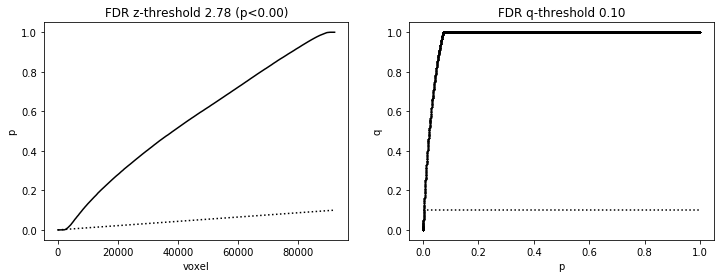

In [10]:
qval = .1

zstat = nib.load(contrasts["loc_3"]).get_data()
thr, zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=None)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (zthr, thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)



1981 1981 1981


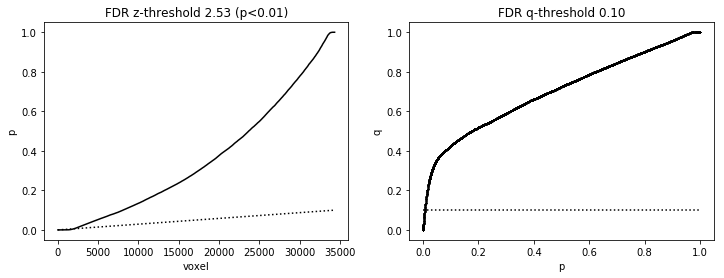

In [11]:
zstat = nib.load(contrasts["loc_1"]).get_data()

qval = .1
thr, zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=mask_ctx, invert_zscores=False)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (zthr, thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [32]:
base_mask = ndimage.filters.convolve(mask_ctx, np.ones((2,2,2)))

zstat = nib.load(contrasts["baseline"]).get_data()
thr, zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=None)

# base_mask *= nib.load(contrasts["baseline"]).get_data() > zthr
# mask_img += nib.load(contrasts["left_upper"]).get_data() > z
# mask_img += nib.load(contrasts["left_lower"]).get_data() > z
# mask_img += nib.load(contrasts["right_upper"]).get_data() > z
# mask_img += nib.load(contrasts["right_lower"]).get_data() > z
# mask_img *= nib.load(mask).get_data() == 2

In [33]:
# Create nifti image.
img = nib.Nifti1Image(
    base_mask.astype(int),
    nib.load(contrasts["baseline"]).affine
)

# Save as nifti.
nib.save(img, os.path.join(post, "base_mask.nii.gz"))

In [34]:
saggital = 0
coronal = 1
axial = 2

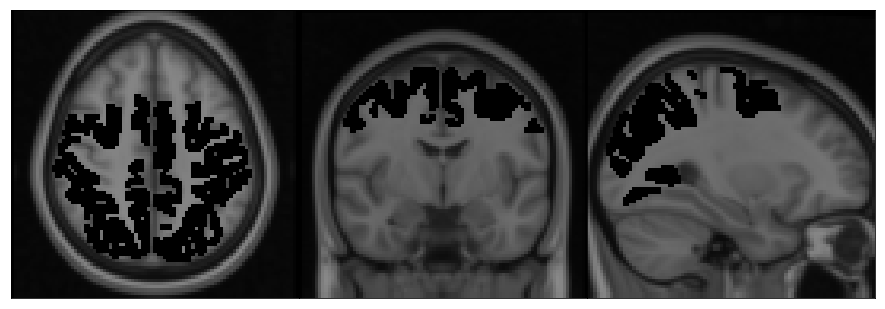

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

axes[0].imshow(np.rot90(mni[:, 10:-10, 60]), cmap=dark, aspect="auto")
masked = np.ma.masked_array(base_mask[:, 10:-10, 60], base_mask[:, 10:-10, 60] == 0)
axes[0].imshow(np.rot90(masked), aspect="auto", cmap="gray")

axes[1].imshow(np.rot90(mni[:, 60, :]), cmap=dark, aspect="auto")
masked = np.ma.masked_array(base_mask[:, 60, :], base_mask[:, 60, :] == 0)
axes[1].imshow(np.rot90(masked), aspect="auto", cmap="gray")

axes[2].imshow(np.rot90(mni[30, 10:-10, :]), cmap=dark, aspect="auto")
masked = np.ma.masked_array(base_mask[30, 10:-10, :], base_mask[30, 10:-10, :] == 0)
axes[2].imshow(np.rot90(masked), aspect="auto", cmap="gray")

for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.subplots_adjust(left=0, hspace=0, wspace=0, right=1, top=1, bottom=0)

## Color lag1

4791 4791 4791


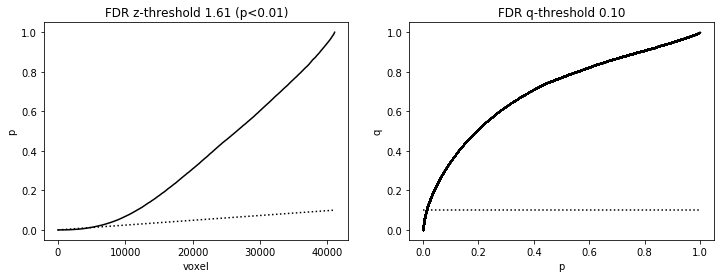

In [36]:
zstat = nib.load(contrasts["clr_lag1_priming"]).get_data()
clr1_masked = zstat * base_mask.astype(int)

# Create nifti image.
img = nib.Nifti1Image(clr1_masked, nib.load(contrasts["clr_lag1_priming"]).affine)
nib.save(img, os.path.join(post, "clr1_masked.nii.gz"))

# clr1_thr, thrline, pval, zscores = fdr(zstat, q=.1, mask=base_mask, invert_zscores=True)

qval = .1
clr1_thr, clr1_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

masked = np.ma.masked_array(clr1_masked, clr1_masked > clr1_zthr)
masked2 = masked * masked.mask

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (zthr, clr1_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= clr1_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [37]:
clr1_peaks = find_peaks( in_file=os.path.join( post, "clr1_masked.nii.gz" ), threshold=clr1_zthr, find_min=True, args="--minextent=8")

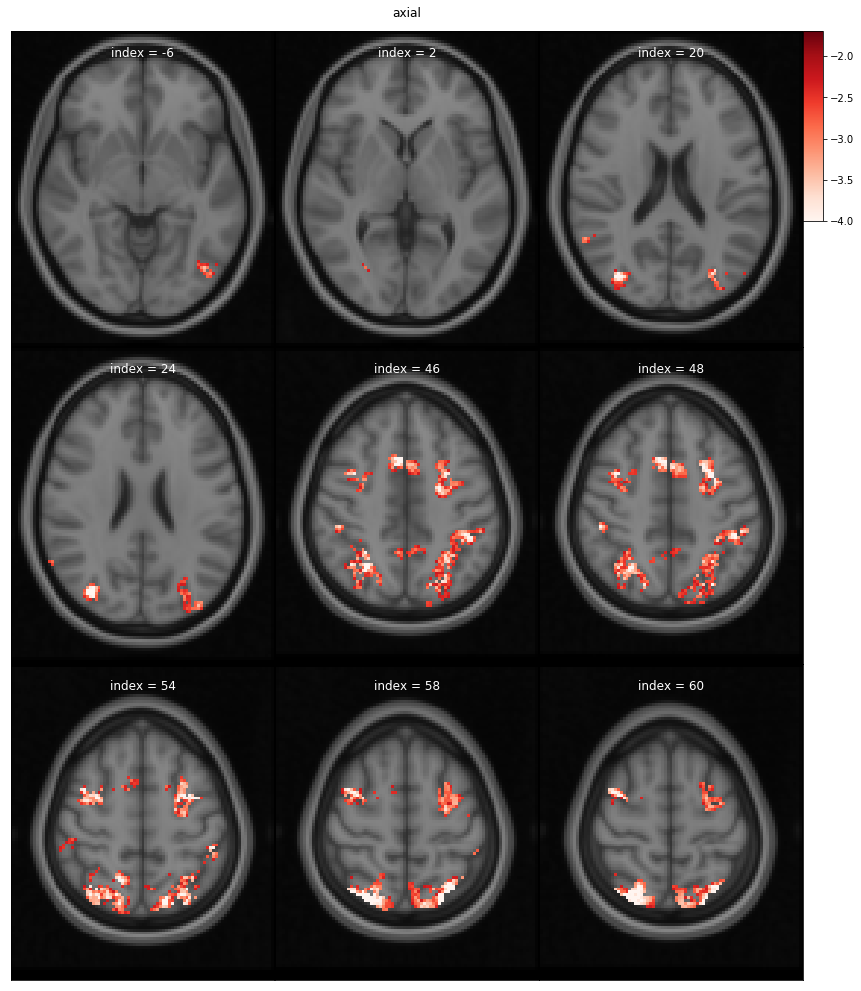

In [38]:
fig, axes = plot_slices(masked, clr1_zthr, clr1_peaks.z.sort_values().unique().tolist(), axial, ncols=3)
fig.suptitle("axial", y=1.025)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

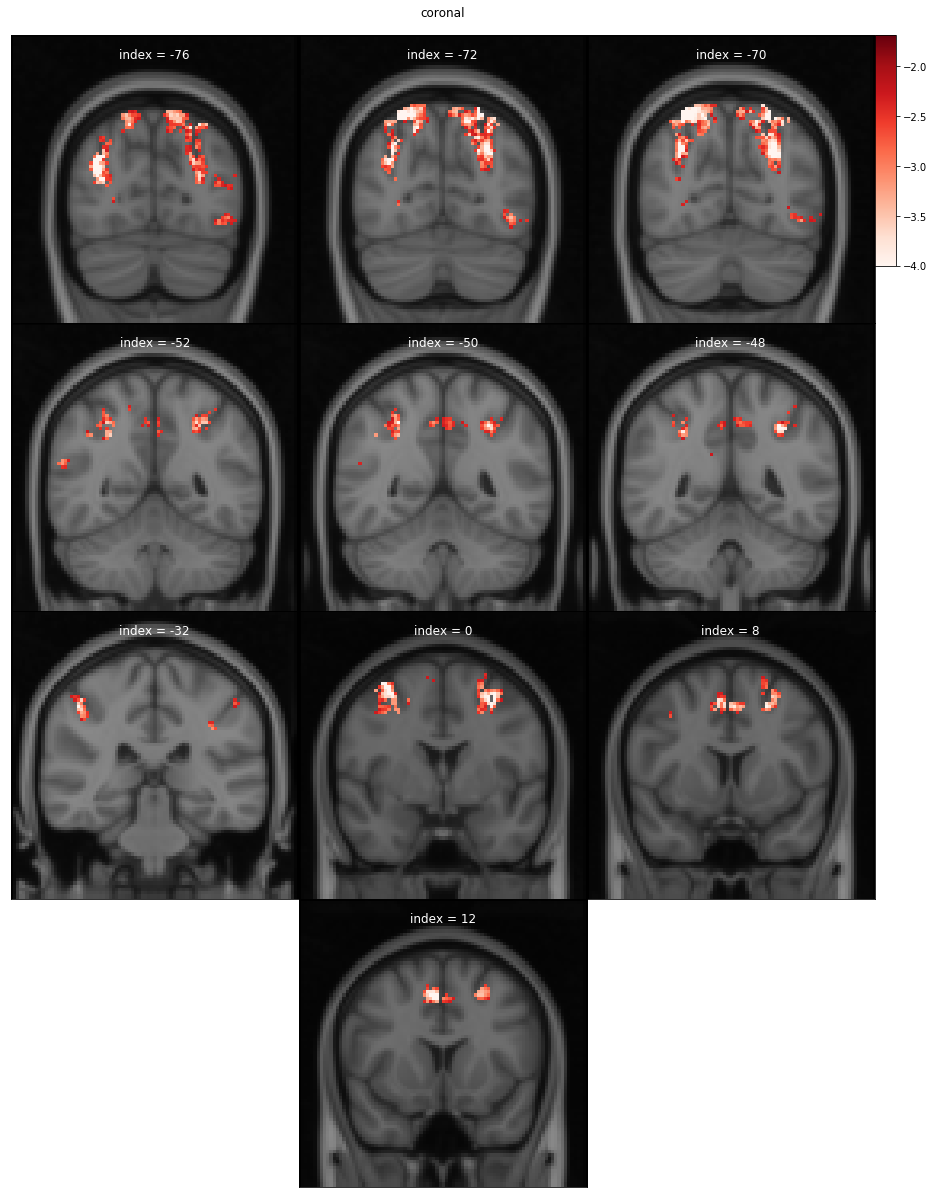

In [39]:
fig, axes = plot_slices(masked, clr1_thr, clr1_peaks.y.sort_values().unique().tolist(), coronal, ncols=3)
fig.suptitle("coronal", y=1.025)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

## Color lag 2

53 40 53


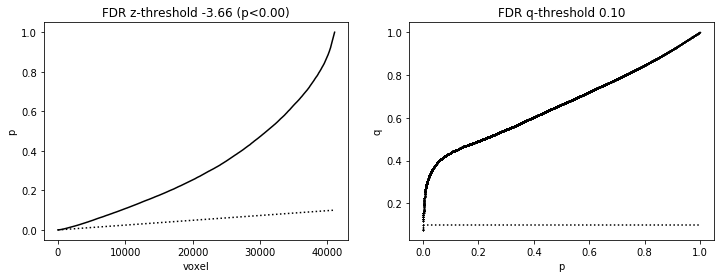

In [40]:
zstat = nib.load(contrasts["clr_lag2_priming"]).get_data()
clr2_masked = zstat * base_mask.astype(int)
aff = nib.load(contrasts["clr_lag2_priming"]).affine
save_nii(clr2_masked, aff, os.path.join(post, "clr2_masked.nii.gz"))

qval = .1
clr2_thr, clr2_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

masked = np.ma.masked_array(clr2_masked, clr2_masked > clr2_zthr)
masked2 = masked * masked.mask

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (clr2_zthr, clr2_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= clr2_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

In [41]:
clr2_peaks = find_peaks( in_file=os.path.join( post, "clr2_masked.nii.gz" ), threshold=clr2_zthr, find_min=True, args="--minextent=8")

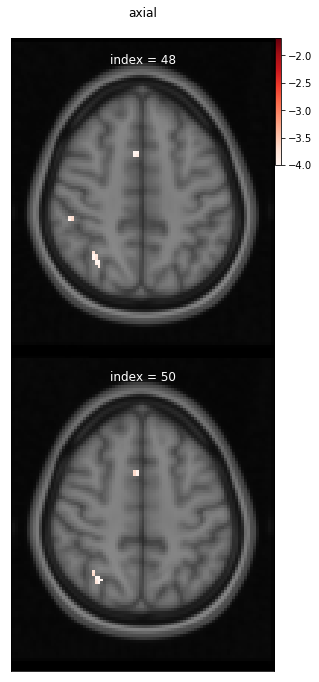

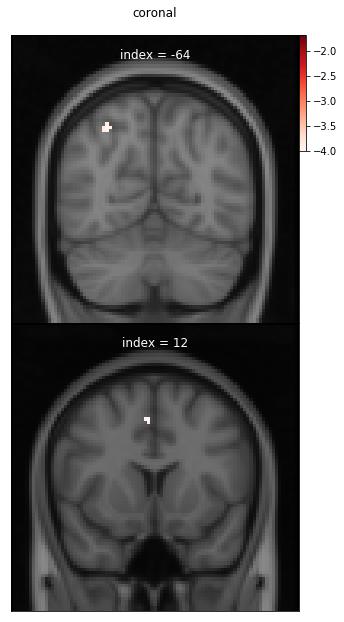

In [43]:
fig, axes = plot_slices(masked, clr2_thr, clr2_peaks.z.sort_values().unique(), axial)
fig.suptitle("axial", y=1.05)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

fig, axes = plot_slices(masked, clr2_thr, clr2_peaks.y.sort_values().unique(), coronal)
fig.suptitle("coronal", y=1.05)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

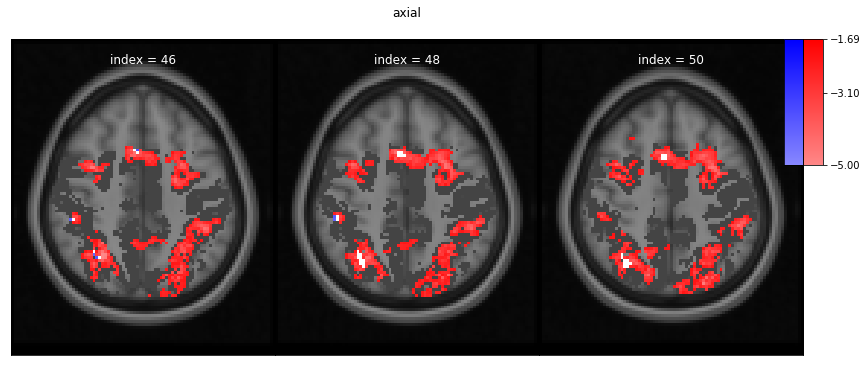

In [27]:
ncols = 3
nrows = int(np.ceil(len(clr2_peaks) / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(len(clr2_peaks), ncols=ncols, figsize=(y, x))

for i, peak in enumerate(clr2_peaks.z.sort_values().unique()):
    idx[axial] = peak
   
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])
    clr2 = np.rot90(nib.load(contrasts["clr_lag2_priming"]).get_data()[idx])

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_zthr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_zthr) & (clr1 < clr1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    im2 = axes[i].imshow(
        masked_clr2, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )

    # Clr 2
    im3 = axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[axial]), color="white", y=.9)

fig.suptitle("axial", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .6, .025, .4])
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .6, .025, .4])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

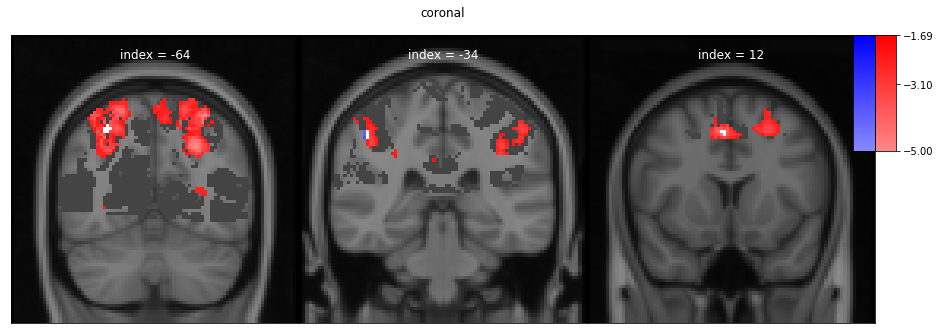

In [28]:
ncols = 3
nrows = int(np.ceil(len(clr2_peaks) / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(len(clr2_peaks), ncols=ncols, figsize=(y, x))

for i, peak in enumerate(clr2_peaks.y.sort_values().unique()):
    idx[coronal] = peak
    
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])
    clr2 = np.rot90(nib.load(contrasts["clr_lag2_priming"]).get_data()[idx])

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_zthr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_zthr) & (clr1 < clr1_zthr)) == 0)
        
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)

    base = np.rot90(base_mask[idx])
    # Base
    axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
    )
    
    # Clr 1
    axes[i].imshow(
        masked_clr1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes[i].imshow(
        masked_clr2,
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )

    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % ( index2mni((peak, peak, peak))[coronal] ), color="white", y=.9)
    

fig.suptitle("coronal", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)
cbar_ax = fig.add_axes([1, .6, .025, .4]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .6, .025, .4])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

438 407 438


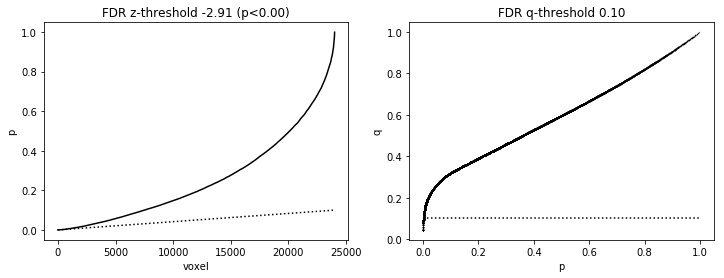

In [29]:
clr1_mask = nib.load(contrasts["clr_lag1_priming"]).get_data() < clr1_thr
clr1_mask *= base_mask

zstat = nib.load(contrasts["clr_lag2_priming"]).get_data()
clr2_masked = zstat * clr1_mask.astype(int)
aff = nib.load(contrasts["clr_lag2_priming"]).affine
save_nii(clr2_masked, aff, os.path.join(post, "clr2_masked.nii.gz"))

qval = .1
clr2_thr, clr2_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=clr1_mask, invert_zscores=True)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (clr2_zthr, clr2_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= clr2_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

NameError: name 'lightblue' is not defined

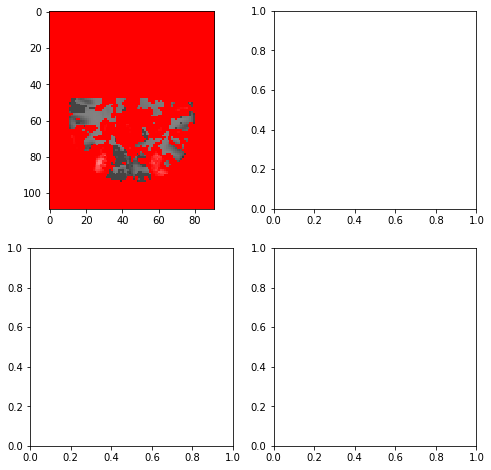

In [30]:
axial_peaks = [51, 60]
coronal_peaks = [30, 68]

fig, (axes1, axes2) = plt.subplots(ncols=len(axial_peaks), nrows=2, figsize=(8, 8))

for i, peak in enumerate(axial_peaks):
    idx = [ slice(None), slice(None), slice(None)]
    idx[axial] = peak
    
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])
    clr2 = np.rot90(nib.load(contrasts["clr_lag2_priming"]).get_data()[idx])

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_thr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_thr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_thr) & (clr1 < clr1_thr)) == 0)
    
    # MNI
    axes1[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    axes1[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    axes1[i].imshow(
        masked_clr1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes1[i].imshow(
        masked_clr2, 
        cmap=lightblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )

    # Clr 2
    axes1[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes1[i].set_xticks([])
    axes1[i].set_yticks([])
    axes1[i].set_title("index = %d" % (index2mni((peak, peak, peak))[axial]))

# Coronal slices
for i, peak in enumerate(coronal_peaks):
    idx = [ slice(None), slice(None), slice(None) ]
    idx[coronal] = peak
    
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])
    clr2 = np.rot90(nib.load(contrasts["clr_lag2_priming"]).get_data()[idx])

    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_thr)
    masked_clr2 = np.ma.masked_array(clr2, clr2 > clr2_thr)
    overlap = np.ma.masked_array(clr2, ((clr2 < clr2_thr) & (clr1 < clr1_thr)) == 0)
        
    # MNI
    axes2[i].imshow(np.rot90(mni[idx]), cmap=dark)

    base = np.rot90(base_mask[idx])
    # Base
    axes2[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
    )
    
    # Clr 1
    axes2[i].imshow(
        masked_clr1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes2[i].imshow(
        masked_clr2,
        cmap=lightblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    # Clr 2
    axes2[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )

    axes2[i].set_xticks([])
    axes2[i].set_yticks([])
    axes2[i].set_title("index = %d" % ( index2mni((peak, peak, peak))[coronal] ))
    
fig.tight_layout()

## Location lag 1

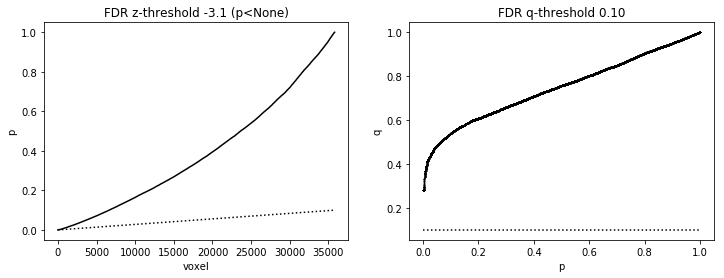

In [31]:
zstat = nib.load(contrasts["loc_lag1_priming"]).get_data()

qval = .1
loc1_thr, loc1_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

loc1_masked = zstat * base_mask.astype(int)
loc1_zthr = -3.1 if not loc1_zthr else loc1_zthr
masked = np.ma.masked_array(loc1_masked, loc1_masked > loc1_zthr)
masked2 = masked * masked.mask

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %s (p<%s)" % (str(loc1_zthr), str(loc1_thr)))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

# print(
#     (pvals <= loc1_thr).sum(),
#     (pcor <= qval).sum(),
#     (padj <= qval).sum()
# )

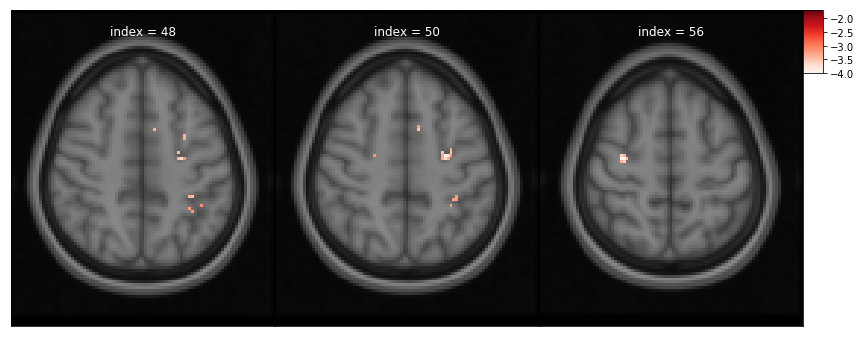

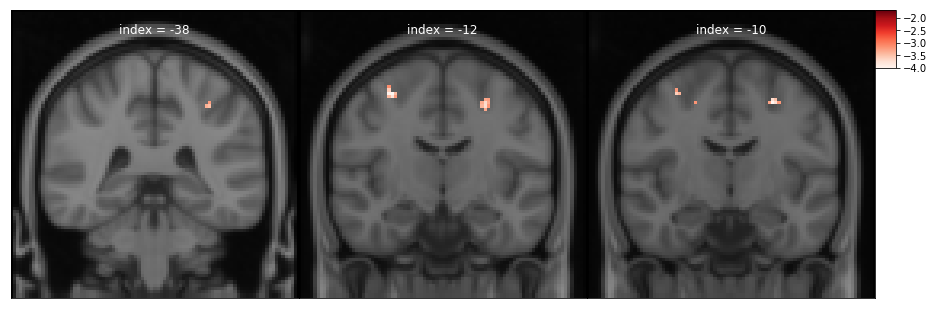

In [32]:
loc1_peaks = find_peaks( in_file=os.path.join( post, "loc1_masked.nii.gz" ), threshold=loc1_zthr, find_min=True, args="--minextent=8")

fig, axes = plot_slices(masked, loc1_thr, loc1_peaks.z.sort_values().unique(), axial, ncols=3)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

fig, axes = plot_slices(masked, loc1_thr, loc1_peaks.y.sort_values().unique(), coronal, ncols=3)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

## Location lag 2

2233 2232 2233


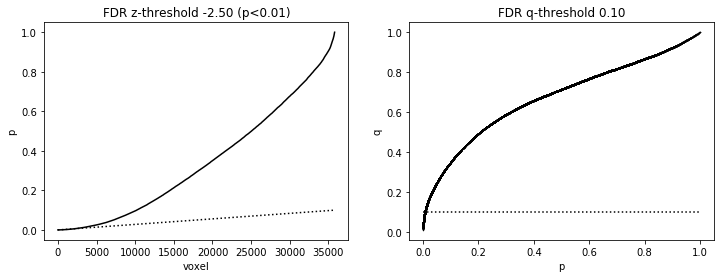

In [33]:
zstat = nib.load(contrasts["loc_lag2_priming"]).get_data()
loc2_masked = zstat * base_mask.astype(int)
aff = nib.load(contrasts["loc_lag2_priming"]).affine
save_nii(loc2_masked, aff, os.path.join(post, "loc2_masked.nii.gz"))

qval = .1
loc2_thr, loc2_zthr, pvals, thrline, pcor, padj = fdr(zstat, q=qval, mask=base_mask, invert_zscores=True)

fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].plot(pvals, "k-")
axes[0].plot(thrline, "k:")
axes[0].set_xlabel("voxel")
axes[0].set_ylabel("p")
axes[1].plot(pvals, padj, "k.", markersize=.5)
axes[1].hlines(qval, xmin=0, xmax=1, linestyle=":", color="#000000")
axes[1].set_xlabel("p")
axes[1].set_ylabel("q")
_ = axes[0].set_title("FDR z-threshold %.2f (p<%.2f)" % (loc2_zthr, loc2_thr))
_ = axes[1].set_title("FDR q-threshold %.2f" % qval)

print(
    (pvals <= loc2_thr).sum(),
    (pcor <= qval).sum(),
    (padj <= qval).sum()
)

masked = np.ma.masked_array(loc2_masked, loc2_masked > loc2_zthr)
masked2 = masked * masked.mask.astype(int)

Text(0.5,0.98,'coronal')

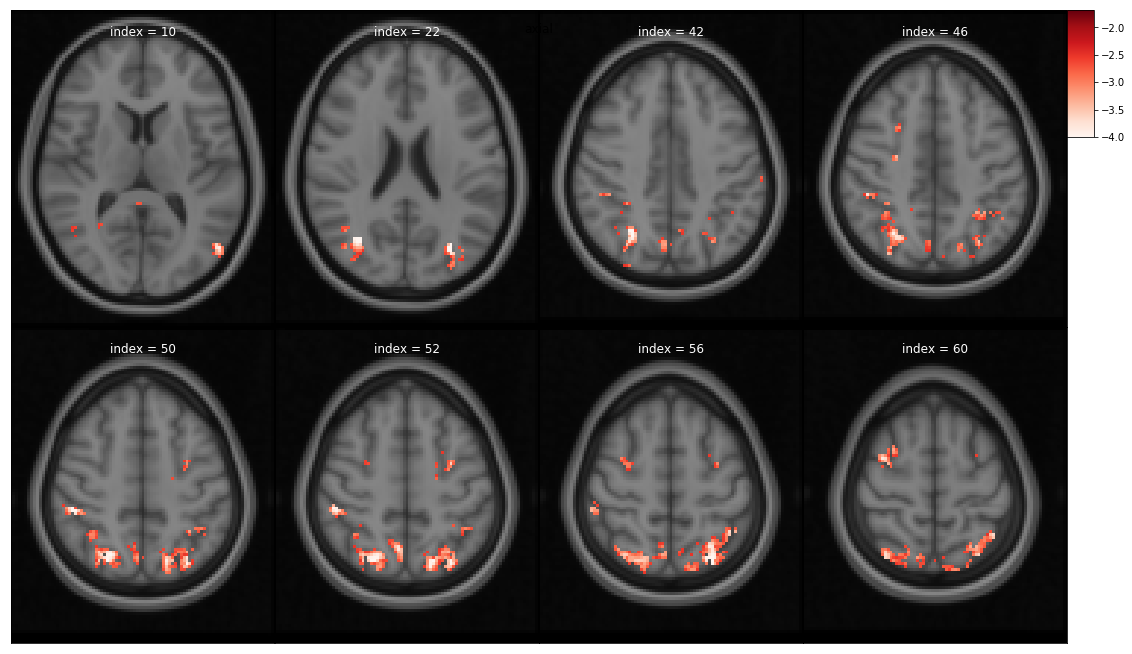

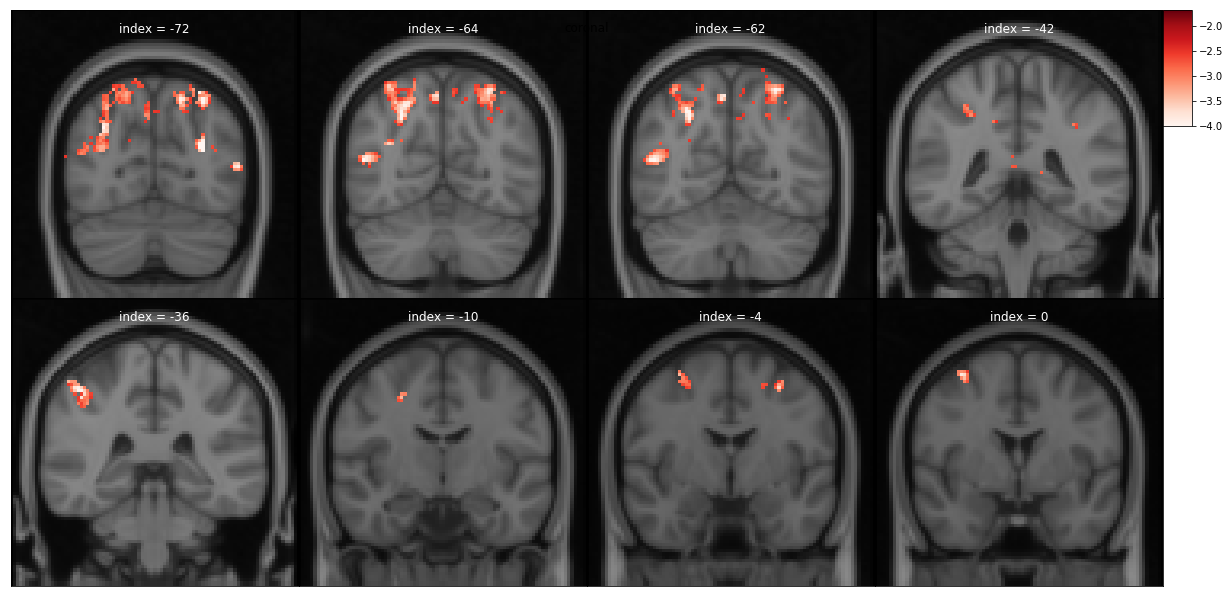

In [34]:
loc2_peaks = find_peaks( in_file=os.path.join( post, "loc2_masked.nii.gz" ), threshold=loc2_zthr, find_min=True, args="--minextent=8")

fig, axes = plot_slices(masked, loc2_thr, loc2_peaks.z.sort_values().unique(), axial, ncols=4)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)
fig.suptitle("axial")

fig, axes = plot_slices(masked, loc2_thr, loc2_peaks.y.sort_values().unique(), coronal, ncols=4)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)
fig.suptitle("coronal")

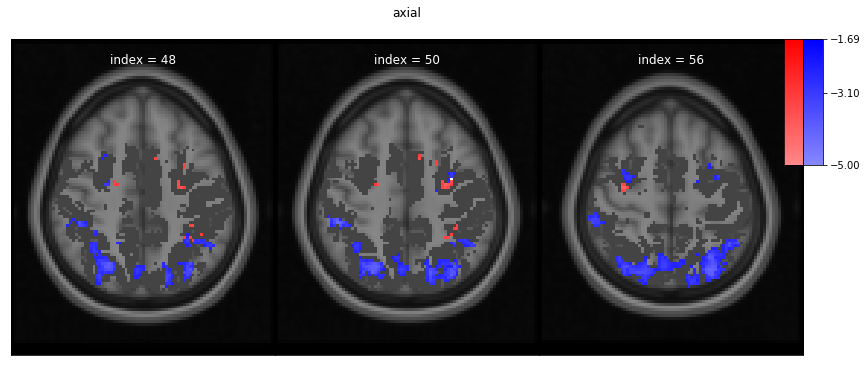

In [35]:
n = len(loc1_peaks.z.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc1_peaks.z.sort_values().unique()):
    idx[axial] = peak
    
    loc1 = np.rot90(nib.load(contrasts["loc_lag1_priming"]).get_data()[idx])
    loc2 = np.rot90(nib.load(contrasts["loc_lag2_priming"]).get_data()[idx])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    overlap = np.ma.masked_array(loc2, ((loc2 < loc2_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    im1 = axes[i].imshow(
        masked_loc2, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[axial]), y=.9, color="white")

fig.suptitle("axial", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .6, .025, .4]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .6, .025, .4])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

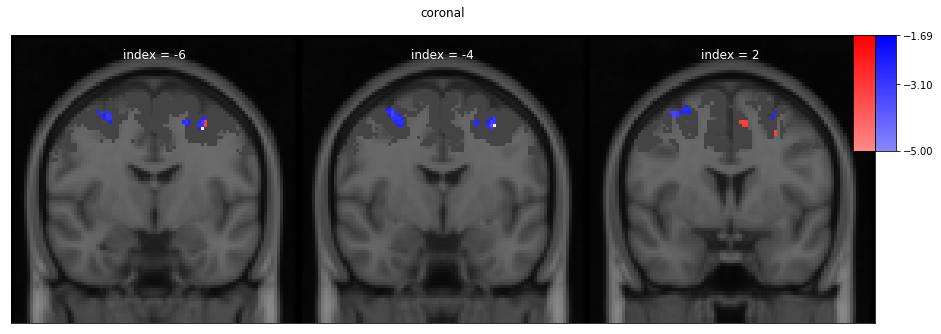

In [36]:
n = len(loc1_peaks.z.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc1_peaks.z.sort_values().unique()):
    idx[coronal] = peak
    
    loc1 = np.rot90(nib.load(contrasts["loc_lag1_priming"]).get_data()[idx])
    loc2 = np.rot90(nib.load(contrasts["loc_lag2_priming"]).get_data()[idx])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    overlap = np.ma.masked_array(loc2, ((loc2 < loc2_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    im1 = axes[i].imshow(
        masked_loc2, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[coronal]), y=.9, color="white")

fig.suptitle("coronal", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .6, .025, .4]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .6, .025, .4])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

## Overlap between color lag 1 and location lag 1

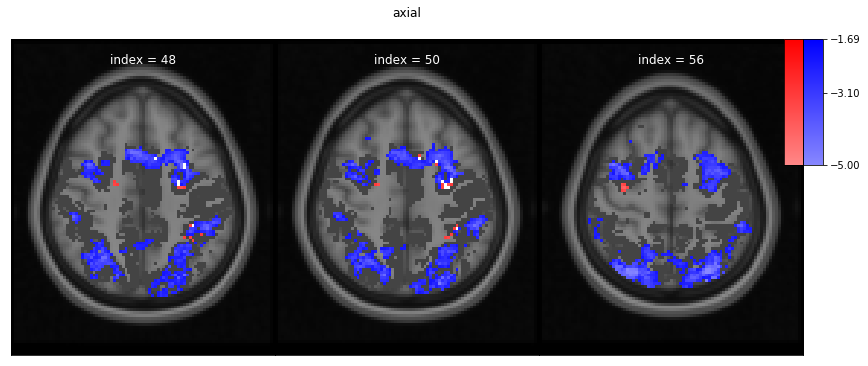

In [39]:
n = len(loc1_peaks.z.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc1_peaks.z.sort_values().unique()):
    idx[axial] = peak
    
    loc1 = np.rot90(nib.load(contrasts["loc_lag1_priming"]).get_data()[idx])
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5 
    )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[axial]), y=.9, color="white")

fig.suptitle("axial", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .6, .025, .4]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .6, .025, .4])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

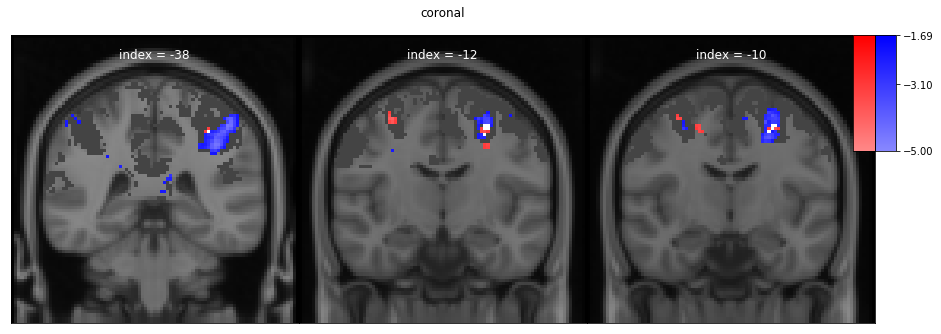

In [40]:
n = len(loc1_peaks.y.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc1_peaks.y.sort_values().unique()):
    idx[coronal] = peak
    
    loc1 = np.rot90(nib.load(contrasts["loc_lag1_priming"]).get_data()[idx])
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])

    masked_loc1 = np.ma.masked_array(loc1, loc1 > loc1_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc1 < loc1_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5 
    )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc1, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[coronal]), y=.9, color="white")

fig.suptitle("coronal", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .6, .025, .4]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .6, .025, .4])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

# Overlap between color lag 1 and location lag 2

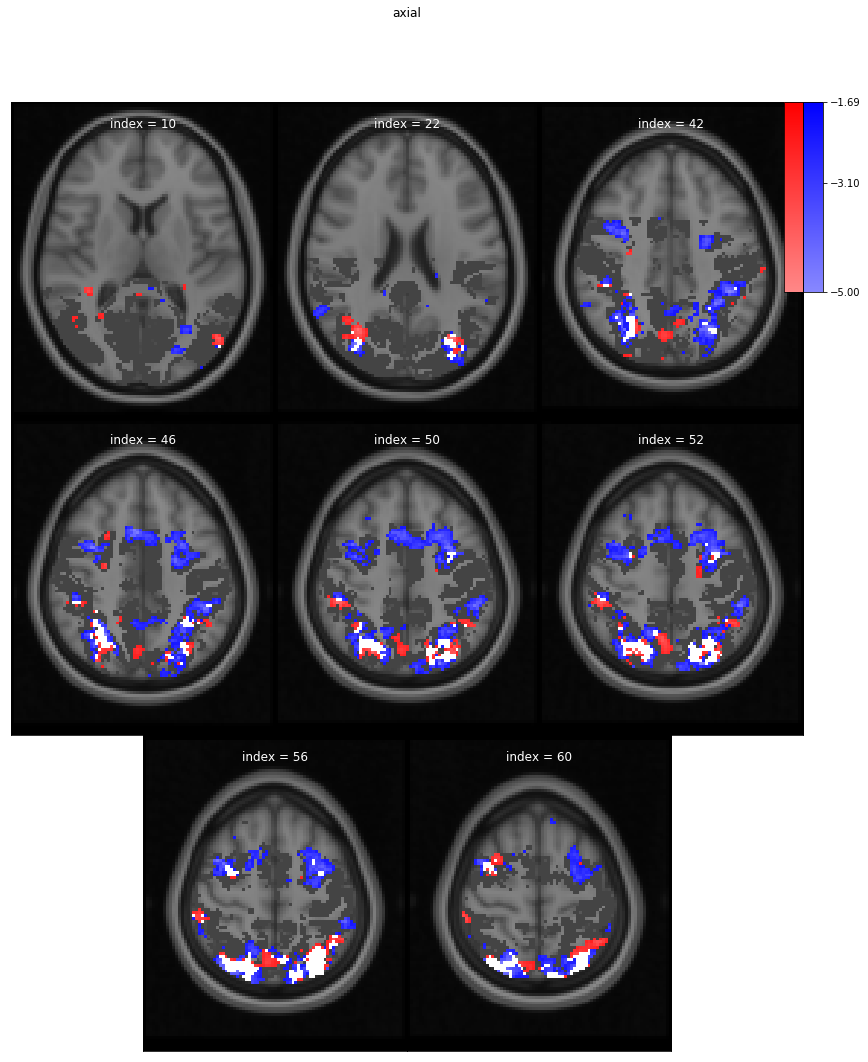

In [45]:
n = len(loc2_peaks.z.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[axial] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc2_peaks.z.sort_values().unique()):
    idx[axial] = peak
    
    loc2 = np.rot90(nib.load(contrasts["loc_lag2_priming"]).get_data()[idx])
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])

    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc2 < loc2_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5 
    )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc2, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[axial]), y=.9, color="white")

fig.suptitle("axial", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .8, .025, .2]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .8, .025, .2])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

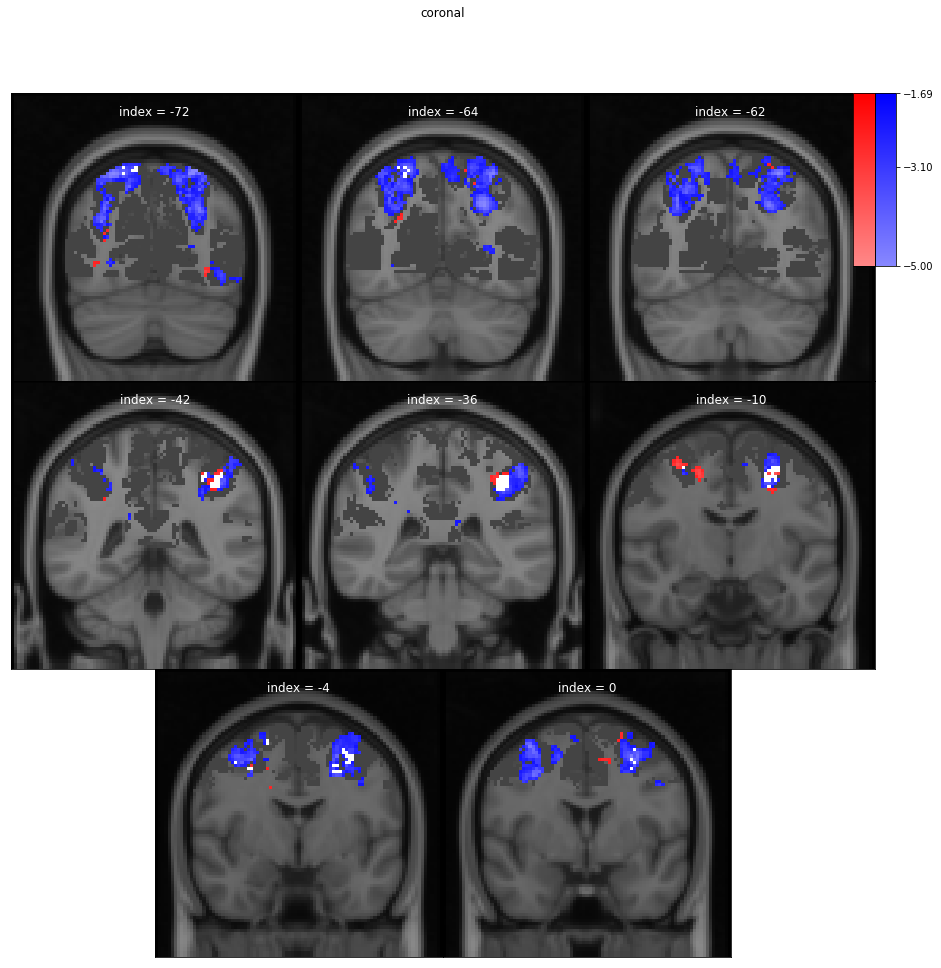

In [47]:
n = len(loc2_peaks.y.sort_values().unique())
ncols = 3
nrows = int(np.ceil(n / ncols))
idx = [ slice(None), slice(None), slice(None)]
idx[coronal] = 50
size = np.array([ncols, nrows]) / np.rot90(mni[idx]).shape * np.mean(np.rot90(mni[idx]).shape) * 4
y, x = size

fig, axes = create_subplots(n, ncols=ncols, figsize=(y, x))

for i, peak in enumerate(loc2_peaks.y.sort_values().unique()):
    idx[coronal] = peak
    
    loc2 = np.rot90(nib.load(contrasts["loc_lag1_priming"]).get_data()[idx])
    clr1 = np.rot90(nib.load(contrasts["clr_lag1_priming"]).get_data()[idx])

    masked_loc2 = np.ma.masked_array(loc2, loc2 > loc2_zthr)
    masked_clr1 = np.ma.masked_array(clr1, clr1 > clr1_zthr)
    
    overlap = np.ma.masked_array(clr1, ((clr1 < clr1_zthr) & (loc2 < loc2_zthr)) == 0)
    
    # MNI
    axes[i].imshow(np.rot90(mni[idx]), cmap=dark)
    
    base = np.rot90(base_mask[idx])
    
    # Base
    im0 = axes[i].imshow(
        np.ma.masked_array(base, base == 0), 
        cmap=darkgray,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5 
    )  
     
    # Clr 2
    im1 = axes[i].imshow(
        masked_clr1, 
        cmap=darkblue,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 1
    im2 = axes[i].imshow(
        masked_loc2, 
        cmap=darkred,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5
    )
    
    # Clr 2
    axes[i].imshow(
        overlap,
        cmap=white,
        aspect=1, 
        interpolation="nearest",
        vmax=-1.69,
        vmin=-5,
        alpha=1,
    )
    
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("index = %d" % (index2mni((peak, peak, peak))[coronal]), y=.9, color="white")

fig.suptitle("coronal", y=1.1)
fig.subplots_adjust(wspace=0, hspace=0, top=1, bottom=0, left=0, right=1)

cbar_ax = fig.add_axes([1, .8, .025, .2]) 
fig.colorbar(im1, cax=cbar_ax, ticks=[-1.69, -3.1, -5])

cbar_ax = fig.add_axes([.975, .8, .025, .2])
fig.colorbar(im2, cax=cbar_ax, ticks=[])

# ROIs

In [36]:
# Cluster
rois_path = os.path.join(post, "clr1_clusters.nii.gz")
cluster = fsl.Cluster(
    threshold=clr1_thr,
    in_file=os.path.join(post, "clr1_masked.nii.gz"),
    args="--minextent=8",
    out_index_file=rois_path,
    find_min=True)

cluster.run()

180930-13:06:17,197 interface INFO:
	 stdout 2018-09-30T13:06:17.196956:Cluster Index	Voxels	MAX	MAX X (vox)	MAX Y (vox)	MAX Z (vox)	COG X (vox)	COG Y (vox)	COG Z (vox)
180930-13:06:17,198 interface INFO:
	 stdout 2018-09-30T13:06:17.196956:14	1941	-5.88	57	28	65	58.6	31.1	58.1
180930-13:06:17,199 interface INFO:
	 stdout 2018-09-30T13:06:17.196956:13	1559	-5.86	27	25	48	30.6	29.1	57.9
180930-13:06:17,199 interface INFO:
	 stdout 2018-09-30T13:06:17.196956:12	547	-4.73	59	63	63	58.7	61.7	62.4
180930-13:06:17,200 interface INFO:
	 stdout 2018-09-30T13:06:17.196956:11	326	-4.69	27	63	66	27.4	62.9	62
180930-13:06:17,202 interface INFO:
	 stdout 2018-09-30T13:06:17.196956:10	123	-4.7	43	69	59	41.1	67.9	60.8
180930-13:06:17,204 interface INFO:
	 stdout 2018-09-30T13:06:17.203959:9	97	-3.45	66	27	33	66.9	26.4	32.3
180930-13:06:17,205 interface INFO:
	 stdout 2018-09-30T13:06:17.203959:8	90	-4.11	21	47	60	21.7	46.3	59.7
180930-13:06:17,206 interface INFO:
	 stdout 2018-09-30T13:06:17.203959:7

In [37]:
img = nib.load(rois_path)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["clr_lag2_priming"])

new_img = np.zeros(zstat.shape)
for i in range(rmin+1, rmax+1):
    mask = (rois == i)     
    clr2_thr, _, _, _ = fdr(zstat.get_data(), q=.1, mask=mask, invert_zscores=True)    
    if clr2_thr is not None:
        roi_select = (zstat.get_data() < clr2_thr)
        mask *= roi_select     
        out = zstat.get_data() * mask.astype(int)
        new_img += out

out_fname = "fdr_roi_overlap.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

num voxels: 73 out of 85
threshold: -1.37
num voxels: 87 out of 90
threshold: -1.31
num voxels: 101 out of 123
threshold: -1.45
num voxels: 216 out of 326
threshold: -1.53
num voxels: 31 out of 547
threshold: -2.49
num voxels: 936 out of 1559
threshold: -1.56
num voxels: 489 out of 1941
threshold: -1.95


In [38]:
# to_surface = freesurfer.SampleToSurface(
#     mni152reg=True,
#     target_subject='fsaverage',
#     subjects_dir=fs_dir,
#     cortex_mask=True,
#     sampling_method="average",
#     sampling_range=(0.2, 0.8, 0.1),
#     sampling_units="frac",
#     smooth_surf=0.0,
#     hemi="rh",
#     source_file=overlap_path)

![title](img/table1.png)

In [76]:
# color
table3 = {
    "l-ips"    : (-26, -62, 48),
    "l-fef"    : (-34, 6,   52),
    "l-lat-occ" : (-36, -72, -6),
    "l-fg"     : (-44, -56, -16),
    "r-ips"    : (40, -48, 58),
    "r-acc"    : (-2, -14, 52),
#     "r-mfg"    : (32, 40, 26),
    "r-occ"    : (12, -88, -8),
    "r-fef"    : (32, -2, 50),
}

In [77]:
mni_path = os.path.join(standard, "MNI152_T1_2mm.nii.gz")
rois = np.zeros(nib.load(mni_path).shape, dtype=int)
sph = Sphere(radius=8)

for i, (roi, mni) in enumerate(table3.items()):

    # To integers
    x, y, z = mni2index(mni)
    
    # Create sphere selection in MNI
    x_slice = slice(x-sph.radius, x+sph.radius+1)
    y_slice = slice(y-sph.radius, y+sph.radius+1)
    z_slice = slice(z-sph.radius, z+sph.radius+1)
    
    rois[x_slice, y_slice, z_slice] = sph.box.astype(int) * (i+1)

rois *= mask_ctx.astype(int)

clr_replication = os.path.join(post, "clr_replication_rois.nii.gz")
save_nii(rois, nib.load(mni_path).affine, clr_replication)

num voxels: 675 out of 859
threshold: -1.44
num voxels: 392 out of 812
threshold: -1.67
num voxels: 10 out of 436
threshold: -2.62
num voxels: 36 out of 667
threshold: -2.56
num voxels: 459 out of 798
threshold: -1.58


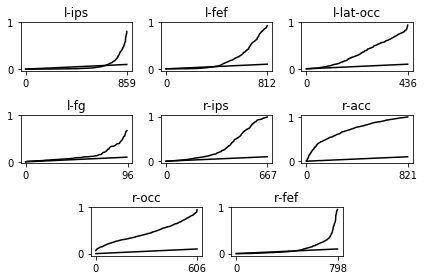

In [78]:
img = nib.load(clr_replication)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["clr_lag1_priming"])

new_img = np.zeros(zstat.shape)
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, thrline, pval, zscores = fdr(zstat.get_data(), q=.1, mask=mask, invert_zscores=True)

    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pval, "k-")
        axes[i].set_title(list(table3.keys())[i])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pval)])
    else:
        axes[i].set_title(list(table3.keys())[i])
        axes[i].text(.2, .5, "out of scope")
        
    if thr is not None:
        roi_select = (zstat.get_data() < thr)
        mask *= roi_select  
        out = zstat.get_data() * mask.astype(int)
        new_img += out

fig.tight_layout()
out_fname = "clr1_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)


num voxels: 61 out of 859
threshold: -2.45
num voxels: 11 out of 667
threshold: -2.96
num voxels: 4 out of 798
threshold: -3.31


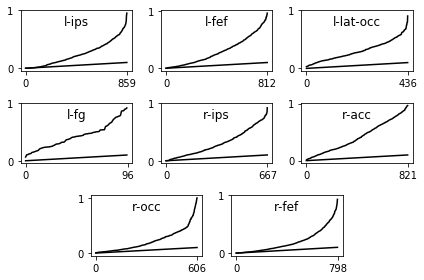

In [87]:
img = nib.load(clr_replication)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["clr_lag2_priming"])
new_img = np.zeros(zstat.shape)
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, thrline, pval, zscores = fdr(zstat.get_data(), q=.1, mask=mask, invert_zscores=True)

    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pval, "k-")
        axes[i].set_title(list(table3.keys())[i])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pval)])
    else:
        axes[i].text(.2, .5, "out of scope")
    
    axes[i].set_title(list(table3.keys())[i], y=.65)
    
    if thr is not None:
        roi_select = (zstat.get_data() < thr)
        mask *= roi_select     
        out = zstat.get_data() * mask.astype(int)
        new_img += out

fig.tight_layout()

out_fname = "clr2_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

![title](img/table2.png)

In [80]:
# location
table2 = {
    "lips"    : (-30, -60, 40),
    "lfef"    : (-32, -12, 54),
#     "lmfg"    : (-34, 36,  18),
    "lpc"     : (-8, -70,  8),
    "rfef"    : (28, -8, 56),
#     "rmfg"    : (28, 26, 22),
#     "rifg"    : (44, -18, -4),
    "racc"    : (2, 22, 36),
    "rap"     : (34, -34, 60),
    "rip"     : (48, -42, 40),
    "rpc"     : (14, -68, 20),
    "rips"    : (24, -66, 48),
}

In [89]:
mni_path = os.path.join(standard, "MNI152_T1_2mm.nii.gz")
rois = np.zeros(nib.load(mni_path).shape, dtype=int)
sph = Sphere(radius=8)

for i, (roi, mni) in enumerate(table2.items()):

    # To integers
    x, y, z = mni2index(mni)
    
    # Create sphere selection in MNI
    x_slice = slice(x-sph.radius, x+sph.radius+1)
    y_slice = slice(y-sph.radius, y+sph.radius+1)
    z_slice = slice(z-sph.radius, z+sph.radius+1)
    
    rois[x_slice, y_slice, z_slice] = sph.box.astype(int) * (i+1)

rois *= mask_ctx.astype(int)

loc_replication_rois = os.path.join(post, "loc_replication_rois.nii.gz")
save_nii(rois, nib.load(mni_path).affine, loc_replication_rois)

num voxels: 114 out of 802
threshold: -2.18
num voxels: 164 out of 713
threshold: -2.00


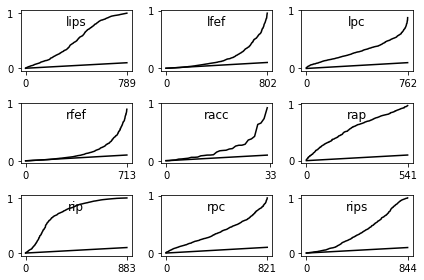

In [93]:
img = nib.load(loc_replication_rois)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["loc_lag1_priming"])
new_img = np.zeros(zstat.shape)
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, thrline, pval, zscores = fdr(zstat.get_data(), q=.1, mask=mask, invert_zscores=True)

    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pval, "k-")
        axes[i].set_title(list(table2.keys())[i])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pval)])
    else:
        axes[i].text(.2, .5, "out of scope")
    
    axes[i].set_title(list(table2.keys())[i], y=.65)
    
    if thr is not None:
        roi_select = (zstat.get_data() < thr)
        mask *= roi_select  
        out = zstat.get_data() * mask.astype(int)
        new_img += out

fig.tight_layout()
out_fname = "loc1_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)

num voxels: 433 out of 789
threshold: -1.60
num voxels: 38 out of 713
threshold: -2.54
num voxels: 40 out of 883
threshold: -2.61
num voxels: 658 out of 844
threshold: -1.42


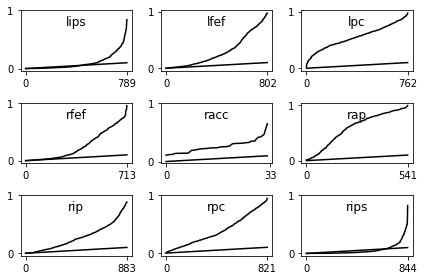

In [96]:
img = nib.load(loc_replication_rois)
rois = img.get_data()
rmin, rmax = rois.min(), rois.max()
zstat = nib.load(contrasts["loc_lag2_priming"])

new_img = np.zeros(zstat.shape)
roi_indexes = range(rmin+1, rmax+1)
fig, axes = create_subplots(len(roi_indexes))
for i, index in enumerate(roi_indexes):
    mask = (rois == index)
    thr, thrline, pval, zscores = fdr(zstat.get_data(), q=.1, mask=mask, invert_zscores=True)

    if len(thrline):
        axes[i].plot(thrline, "k-")
        axes[i].plot(pval, "k-")
        axes[i].set_title(list(table2.keys())[i])
        axes[i].set_yticks([0, 1])
        axes[i].set_xticks([0, len(pval)])
    else:
        axes[i].text(.2, .5, "out of scope")
    
    axes[i].set_title(list(table2.keys())[i], y=.65)
    
    if thr is not None:
        roi_select = (zstat.get_data() < thr)
        mask *= roi_select  
        out = zstat.get_data() * mask.astype(int)
        new_img += out

fig.tight_layout()
out_fname = "loc2_replication.nii.gz"
overlap_path = os.path.join(output, "postprocessing", out_fname)
save_nii(new_img, zstat.affine, overlap_path)